In [64]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-jct5cyyh
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-jct5cyyh
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 39515ff0fcdae55bbbf546d90193dbe54b201556
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Epoch 0/1000 (LR=0.001), Training Loss: 0.0901, Validation Loss: 0.0019
Epoch 1/1000 (LR=0.001), Training Loss: 0.0013, Validation Loss: 0.0011
Epoch 2/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0009
Epoch 3/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0008
Training stopped at epoch 4 because training loss < 0.001
(21, 5)
(3522, 1)


<ipython-input-65-45ff10b025d1>:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


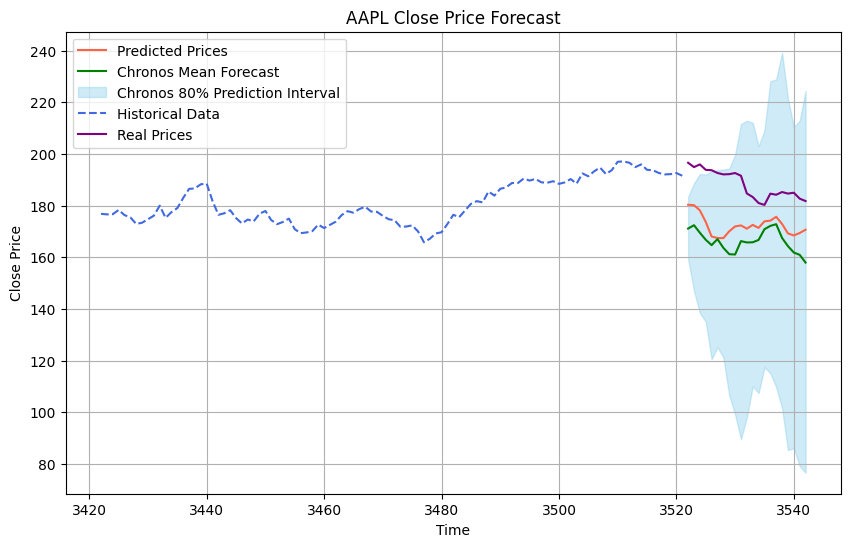

In [65]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map=DEVICE,
    torch_dtype=torch.bfloat16,
)

# Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2010-01-01", end="2023-12-31", progress=False)

# Usa tutte le colonne utili
df = data.reset_index()
covariates = df[["Open", "High", "Low", "Volume", "Close"]].values  # Dati reali
close_prices = df["Close"].values  # Prezzo reale di chiusura

# Finestra mobile per generare il dataset
def generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50):
    X = []
    Y = []
    for t in range(len(covariates) - window_size):
        # Finestra di covariate
        window = covariates[t:t+window_size]

        # Previsione con Chronos per ciascuna covariata
        means = []
        for i in range(window.shape[1]):  # Itera sulle variabili
            context = torch.tensor(window[:, i])  # Serie univariata
            forecast = pipeline.predict(context=context, prediction_length=1)  # Predice il giorno successivo
            mean_forecast = np.mean(forecast[0].numpy())  # Media della distribuzione
            means.append(mean_forecast)

        # Input: Medie delle covariate
        X.append(means)

        # Ground truth: Prezzo di chiusura reale del giorno successivo
        Y.append(close_prices[t+window_size])

    return np.array(X), np.array(Y)

# Genera il dataset
X, Y = generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50)

# Normalizza covariate
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

# Normalizza variabile risposta
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

# Dividi i dati in training e validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

# Converti in tensori PyTorch
X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32)
Y_val_split = torch.tensor(Y_val_split, dtype=torch.float32)

class PricePredictionNN(nn.Module):
        def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
            super(PricePredictionNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size_1)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(0.1)
            self.fc3 = nn.Linear(hidden_size_2, output_size)

        def forward(self, x):
            x = self.dropout1(self.relu1(self.fc1(x)))
            x = self.dropout2(self.relu2(self.fc2(x)))
            x = self.fc3(x)
            return x

LR = 0.001 # Initial learning rate
WEIGHT_DECAY = 4e-5 # Regularization
STEP_SIZE = [150, 300, 600] # Number of epochs before decreasing LR
GAMMA = 0.1 # Multiplicative factor for learning rate step-down

# Creazione del modello
input_size = X.shape[1]  # Numero di feature
hidden_size_1 = 128  # Numero di unità nascoste
hidden_size_2 = 64  # Numero di unità nascoste
output_size = 1  # Prezzo di chiusura predetto
model = PricePredictionNN(input_size, hidden_size_1, hidden_size_2, output_size)

# Ottimizzatore e funzione di perdita
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
criterion = nn.MSELoss()  # Mean Squared Error
scheduler = MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)

# Creazione del DataLoader per il training
batch_size = 32  # Numero di campioni per batch
train_dataset = TensorDataset(X_train_split, Y_train_split)
val_dataset = TensorDataset(X_val_split, Y_val_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping
best_loss = float("inf")
patience = 100  # Numero massimo di epoche senza miglioramenti
patience_counter = 0

loss_history = []
loss_history_val = []

# Inizializzazione del training
num_epochs = 1000
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0

    # Training loop
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)

        # Backpropagation e aggiornamento
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Media della loss per batch
    loss_history.append(train_loss)

    # Validation loop
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions_list = []

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            val_predictions = model(batch_X)
            val_predictions_list.append(val_predictions.numpy())  # Salviamo le previsioni

            loss = criterion(val_predictions, batch_Y)
            val_loss += loss.item()

    # Convertiamo l'elenco in array numpy
    val_predictions = np.concatenate(val_predictions_list, axis=0)

    # Riportiamo i dati alla scala originale
    val_predictions_original = scaler_y.inverse_transform(val_predictions)

    val_loss /= len(val_loader)  # Media della loss per batch
    loss_history_val.append(val_loss)

    # Step del learning rate scheduler
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch}/{num_epochs} (LR={current_lr}), Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Salva il miglior modello
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Interruzione del training se la loss scende sotto 0.001
    if train_loss < 0.001:
        print(f"Training stopped at epoch {epoch+1} because training loss < 0.001")
        break

# Nuovi dati
new_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
#new_covariates = new_data[["Open", "High", "Low", "Volume", "Close"]].values
#new_close_prices = new_data["Close"].values

# Definiamo il numero di giorni della finestra temporale
window_size = 10  # Stesso valore usato nel training

# Estendiamo i dati di test includendo gli ultimi `window_size` giorni del training
extended_new_data = pd.concat([df.iloc[-window_size:], new_data])  # Unisce ultimi giorni training + test

# Estraiamo le feature
new_covariates = extended_new_data[["Open", "High", "Low", "Volume", "Close"]].values
new_close_prices = extended_new_data["Close"].values

# Genera dati di test con la finestra mobile
X_test, Y_test = generate_dataset_with_chronos(new_covariates, new_close_prices, pipeline)
X_test = scaler_x.transform(X_test)

print(X_test.shape)

# Converti in tensore
X_test = torch.tensor(X_test, dtype=torch.float32)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

test_predictions = scaler_y.inverse_transform(test_predictions)

print(close_prices.shape)

# Indici temporali per i dati storici e di test
historical_index = np.arange(len(close_prices))  # Dati storici
test_index = np.arange(len(close_prices), len(close_prices) + len(test_predictions))

# Riduci le dimensioni del contesto e della lunghezza della previsione per Chronos
chronos_context = torch.tensor(close_prices[-100:])  # Usa gli ultimi 500 punti dati come contesto
chronos_prediction_length = len(test_predictions)

chronos_forecast = pipeline.predict(context=chronos_context, prediction_length=chronos_prediction_length)
low, median, high = np.quantile(chronos_forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(chronos_forecast[0].numpy(), axis=0)

# Assicurati che i vettori abbiano le dimensioni corrette
mean_forecast = mean_forecast[:len(test_predictions)]
low = low[:len(test_predictions)]
high = high[:len(test_predictions)]


# Grafico
plt.figure(figsize=(10, 6))

plt.plot(test_index, test_predictions, color="tomato", label="Predicted Prices")  # Nostre previsioni
plt.plot(test_index, mean_forecast, color="green", label="Chronos Mean Forecast") # Chronos
plt.fill_between(test_index, low, high, color="skyblue", alpha=0.4, label="Chronos 80% Prediction Interval")  # Chronos confidence

# Plot the history, only last 50 timesteps
plt.plot(historical_index[-100:], close_prices[-100:], color="royalblue", label="Historical Data", linestyle='--')  # Storico


# Plot the "real" line
plt.plot(test_index, new_close_prices[:len(test_predictions)], color="purple", label="Real Prices") #Taglio per allineare i vettori

plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcola MAE, RMSE e MAPE per il tuo modello
mae_nn = mean_absolute_error(new_close_prices[:len(test_predictions)], test_predictions)
rmse_nn = mean_squared_error(new_close_prices[:len(test_predictions)], test_predictions)
mape_nn = np.mean(np.abs((new_close_prices[:len(test_predictions)] - test_predictions) / new_close_prices[:len(test_predictions)])) * 100

# Calcola MAE, RMSE e MAPE per Chronos
mae_chronos = mean_absolute_error(new_close_prices[:len(mean_forecast)], mean_forecast)
rmse_chronos = mean_squared_error(new_close_prices[:len(mean_forecast)], mean_forecast)
mape_chronos = np.mean(np.abs((new_close_prices[:len(mean_forecast)] - mean_forecast) / new_close_prices[:len(mean_forecast)])) * 100

# Stampa i risultati
print("=== MODEL PERFORMANCE COMPARISON ===")
print(f"Neural Network -> MAE: {mae_nn:.4f}, RMSE: {rmse_nn:.4f}, MAPE: {mape_nn:.2f}%")
print(f"Chronos        -> MAE: {mae_chronos:.4f}, RMSE: {rmse_chronos:.4f}, MAPE: {mape_chronos:.2f}%")

=== MODEL PERFORMANCE COMPARISON ===
Neural Network -> MAE: 15.9300, RMSE: 284.3647, MAPE: 8.40%
Chronos        -> MAE: 22.0594, RMSE: 525.6188, MAPE: 11.64%


<ipython-input-67-be0620d4397a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Day 0: Actual Price = [184.73498535], Predicted Price = 184.83189009712873, Decision = HOLD
Day 1: Actual Price = [183.35176086], Predicted Price = 182.80891256058914, Decision = HOLD
Day 2: Actual Price = [181.02316284], Predicted Price = 180.50773184719952, Decision = HOLD
Day 3: Actual Price = [180.29672241], Predicted Price = 179.96088760869756, Decision = HOLD
Day 4: Actual Price = [184.65536499], Predicted Price = 182.031423737609, Decision = HOLD
Day 5: Actual Price = [184.2374115], Predicted Price = 182.32408281676945, Decision = HOLD
Day 6: Actual Price = [185.28230286], Predicted Price = 183.3757430787075, Decision = HOLD
Day 7: Actual Price = [184.68521118], Predicted Price = 183.86002906840358, Decision = HOLD
Day 8: Actual Price = [185.01359558], Predicted Price = 184.02283701038814, Decision = HOLD
Day 9: Actual Price = [182.73477173], Predicted Price = 181.1665496482769, Decision = HOLD
Day 10: Actual Price = [181.78939819], Predicted Price = 180.02348564439055, Decision

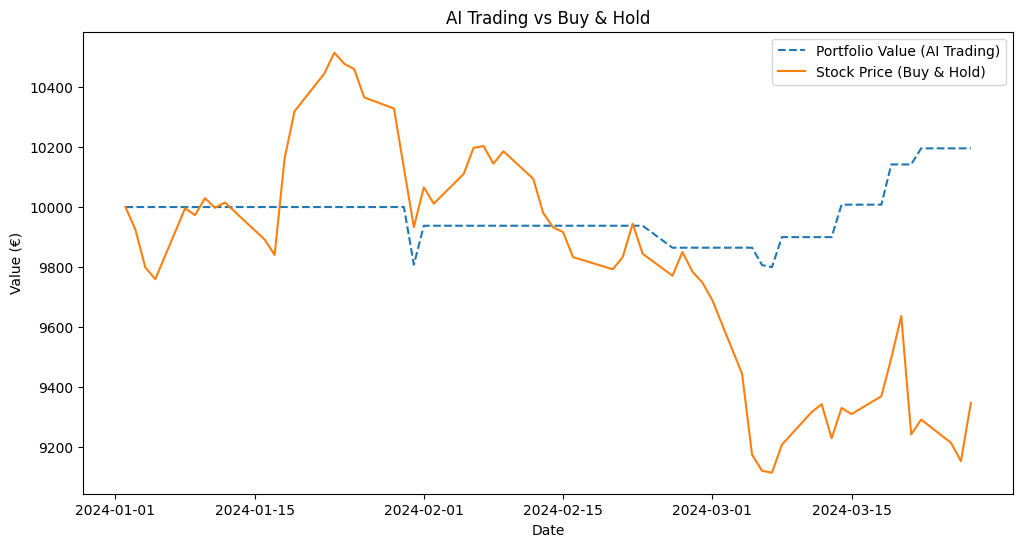

In [67]:
# Caricamento del modello
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Scarica i dati del 2023
symbol = "AAPL"
test_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)

# Prepara i dati
test_features = test_data[["Open", "High", "Low", "Volume", "Close"]].values
test_close_prices = test_data["Close"].values

# Normalizza i dati con lo stesso scaler del training
X_test_scaled = scaler_x.transform(test_features)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Simulazione del Trading
budget = 10000  # Capitale iniziale
shares_held = 0  # Numero di azioni possedute
portfolio_values = []  # Lista per tracciare il valore del portafoglio
actions_taken = []  # Traccia le decisioni giornaliere

for i in range(len(X_test) - 1):
    current_price = test_close_prices[i]

    with torch.no_grad():
        predicted_price_tomorrow_scaled = model(X_test[i].unsqueeze(0)).item()

    predicted_price_tomorrow = scaler_y.inverse_transform([[predicted_price_tomorrow_scaled]])[0, 0]

    # Variabile per la decisione
    decision = "HOLD"

    if predicted_price_tomorrow > current_price * 1.001 and budget >= current_price:
        shares_to_buy = budget // current_price
        shares_held += shares_to_buy
        budget -= shares_to_buy * current_price
        decision = "BUY"
    elif predicted_price_tomorrow < current_price * 0.999 and shares_held > 0:
        budget += shares_held * current_price
        shares_held = 0
        decision = "SELL"

    actions_taken.append(decision)

    # Stampa con decisione inclusa
    print(f"Day {i}: Actual Price = {current_price}, Predicted Price = {predicted_price_tomorrow}, Decision = {decision}")

    # Calcola il valore del portafoglio e salvalo
    portfolio_value = budget + (shares_held * current_price)
    portfolio_values.append(portfolio_value)

# Valore finale del portafoglio
final_value = budget + (shares_held * test_close_prices[-1])
print(f"\nFinal Portfolio Value: {final_value}€")

# Grafico del portafoglio vs. prezzo reale
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:-1], portfolio_values, label="Portfolio Value (AI Trading)", linestyle="dashed")
plt.plot(test_data.index[:-1], test_close_prices[:-1] * (10000 / test_close_prices[0]), label="Stock Price (Buy & Hold)")
plt.xlabel("Date")
plt.ylabel("Value (€)")
plt.title("AI Trading vs Buy & Hold")
plt.legend()
plt.show()

Day 0: Actual Price = [184.73498535], Predicted Price = [184.73498535], Decision = HOLD
Day 1: Actual Price = [183.35176086], Predicted Price = 180.53646850585938, Decision = HOLD
Day 2: Actual Price = [181.02316284], Predicted Price = 312.92535400390625, Decision = BUY
Day 3: Actual Price = [180.29672241], Predicted Price = 179.7915802001953, Decision = SELL
Day 4: Actual Price = [184.65536499], Predicted Price = 174.91586303710938, Decision = HOLD
Day 5: Actual Price = [184.2374115], Predicted Price = 173.7646484375, Decision = HOLD
Day 6: Actual Price = [185.28230286], Predicted Price = 180.46875, Decision = HOLD
Day 7: Actual Price = [184.68521118], Predicted Price = 284.34832763671875, Decision = BUY
Day 8: Actual Price = [185.01359558], Predicted Price = 183.92236328125, Decision = SELL
Day 9: Actual Price = [182.73477173], Predicted Price = 185.005859375, Decision = BUY
Day 10: Actual Price = [181.78939819], Predicted Price = 308.523681640625, Decision = HOLD
Day 11: Actual Pric

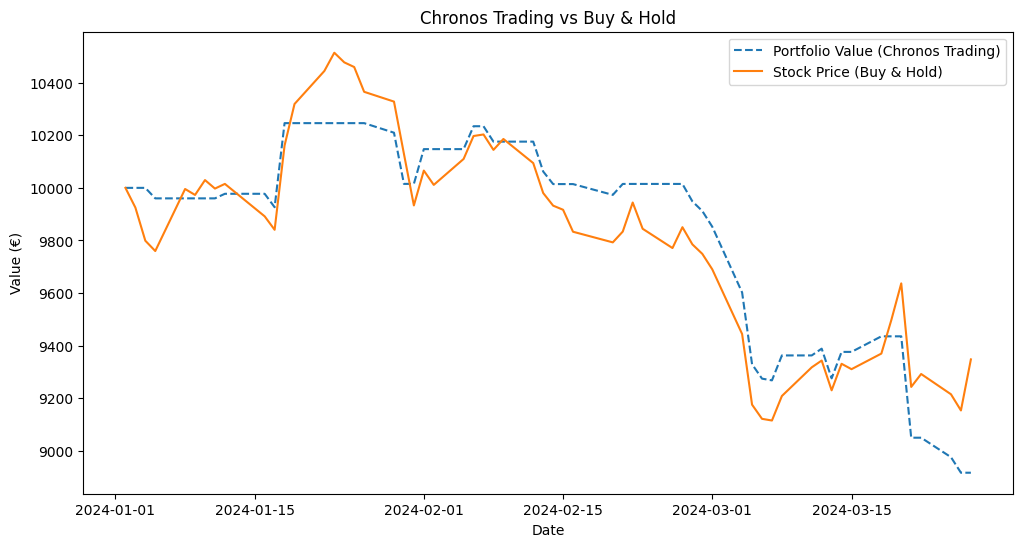

In [69]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Caricamento del modello Chronos
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map=DEVICE,
    torch_dtype=torch.bfloat16,
)

# Scarica i dati del 2023
symbol = "AAPL"
test_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)

# Prepara i dati
test_features = test_data[["Open", "High", "Low", "Volume", "Close"]].values
test_close_prices = test_data["Close"].values

# Simulazione del Trading
budget = 10000  # Capitale iniziale
shares_held = 0  # Numero di azioni possedute
portfolio_values = []  # Lista per tracciare il valore del portafoglio
actions_taken = []  # Traccia le decisioni giornaliere

for i in range(len(test_close_prices) - 1):
    current_price = test_close_prices[i]

    # Assicuriamoci che il contesto non sia vuoto
    if i > 0:  # Assicura che ci sia almeno un dato nel contesto
        context = torch.tensor(test_close_prices[max(0, i-100):i], dtype=torch.float32)
        if len(context) > 0:  # Assicura che il contesto non sia vuoto
            chronos_forecast = pipeline.predict(context=context, prediction_length=1)
            predicted_price_tomorrow = np.mean(chronos_forecast[0].numpy())
        else:
            predicted_price_tomorrow = current_price  # Fallback: usa il prezzo attuale
    else:
        predicted_price_tomorrow = current_price  # Fallback per il primo giorno

    # Decisione di trading
    decision = "HOLD"
    if predicted_price_tomorrow > current_price * 1.001 and budget >= current_price:
        shares_to_buy = budget // current_price
        shares_held += shares_to_buy
        budget -= shares_to_buy * current_price
        decision = "BUY"
    elif predicted_price_tomorrow < current_price * 0.999 and shares_held > 0:
        budget += shares_held * current_price
        shares_held = 0
        decision = "SELL"

    actions_taken.append(decision)

    # Stampa con decisione inclusa
    print(f"Day {i}: Actual Price = {current_price}, Predicted Price = {predicted_price_tomorrow}, Decision = {decision}")

    # Calcola il valore del portafoglio e salvalo
    portfolio_value = budget + (shares_held * current_price)
    portfolio_values.append(portfolio_value)

# Valore finale del portafoglio
final_value = budget + (shares_held * test_close_prices[-1])
print(f"\nFinal Portfolio Value: {final_value}€")

# Grafico del portafoglio vs. prezzo reale
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:-1], portfolio_values, label="Portfolio Value (Chronos Trading)", linestyle="dashed")
plt.plot(test_data.index[:-1], test_close_prices[:-1] * (10000 / test_close_prices[0]), label="Stock Price (Buy & Hold)")
plt.xlabel("Date")
plt.ylabel("Value (€)")
plt.title("Chronos Trading vs Buy & Hold")
plt.legend()
plt.show()